In [64]:
%pip install requests pandas matplotlib seaborn jupyterlab --quiet

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Carregar o arquivo CSV

In [66]:
csv_path = Path("output/classificacoes_relatorios.csv")
df = pd.read_csv(csv_path, encoding='utf-8')

print(f"Total de linhas: {len(df)}")
print(f"Total de colunas: {len(df.columns)}")
print(f"\nColunas: {list(df.columns)}")

Total de linhas: 150
Total de colunas: 14

Colunas: ['Arquivo', 'Planilha', 'UF', 'Município', 'Desastres', 'Processo', 'Protocolo', 'Data Criação', 'Data Solicitação', 'Valor Solicitado', 'Status', 'Analista', 'Solicitação', 'Categoria da Solicitação']


## Visualizar as primeiras linhas

In [67]:
df.head(10)

,Arquivo,Planilha,UF,Município,Desastres,Processo,Protocolo,Data Criação,Data Solicitação,Valor Solicitado,Status,Analista,Solicitação,Categoria da Solicitação
0,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,RS,São Jerônimo,Enxurradas,NaN,REC-RS-4318408-20170202-02,02/02/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
1,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,RS,São Jerônimo,Enxurradas,NaN,REC-RS-4318408-20170206-04,06/02/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
2,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,RS,São Jerônimo,Enxurradas,59053.000123/2017-24,REC-RS-4318408-20170206-07,06/02/2017,14/02/2017,"802048,85",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Brenner Ferreira Soares,"AÇÕES DE RECUPERAÇÃO - Desastre por ENXURRADAS - Decreto Municipal nº. 4768, de 04 de janeiro de 2017.\r\nOBJETO: Obras de reconstrução de pontilhões no interior do município de São Jerônimo",Reconstrução de Infraestrutura
3,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,SC,Brusque,Enxurradas,59053.000161/2017-87,REC-SC-4202909-20170216-02,16/02/2017,22/02/2017,"399041,28",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Henrique Silva Campos Júnior,"Plano de trabalho referente a Enxurrada ocorrida no dia 05/01/2017 no município de Brusque Santa Catarina, visando a obtenção de recursos Federais para reconstrução de 08 Unidades habitacionais, a serem reconstruídas em locais diferentes dos afetados pelo desastre mencionado, em local a ser definido pelo município.\r\nMeta 01 - Reconstrução de residência afetada por deslizamento, Localizada na Rua Nicolau Lauritizem, Bairro Guarani;\r\nMeta 02 - Reconstrução de residência atingida por deslizamento, localizada a Rua Luiz Rafael Flor, nº 180, Bairro Nova Brasilia;\r\nMeta 03 - Reconstrução de residência afetada estruturalmente por alagamento, Localizada a Rua Joaquim Zucco, nº 656, Bairro Nova Brasilia;\r\nMeta 04 - Reconstrução de residencia atingida por deslizamento, Localizada a Rua Florêncio Day, Bairro Azambuja;\r\nMeta 05 - Reconstrução de residência Multifamiliar, composta por 04 Unidades habitacionais, Afetada por erosões em virtude das enxurradas, Localizada a Rua José Winter, nº273.",Reconstrução de Habitação
4,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,SE,Porto da Folha,Seca,NaN,REC-SE-2805604-20170317-01,17/03/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
5,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,ES,Água Doce do Norte,Inundações,59053.000462/2017-19,REC-ES-3200169-20170327-01,27/03/2017,29/05/2017,"1189137,30",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Márcio Pinto Martins,,NaN
6,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,ES,Iconha,Enxurradas,NaN,REC-ES-3202603-20170331-02,31/03/2017,NaN,NaN,ARQUIVADO - PLANO DE TRABALHO EXCLUÍDO,NaN,,NaN
7,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,PA,Santa Maria das Barreiras,Enxurradas,59053.000384/2017-44,REC-PA-1506583-20170406-01,06/04/2017,04/05/2017,"3223222,97",ACOMPANHAMENTO - RECURSO TRANSFERIDO,Sofia Moreira Campos,RECONSTRUÇÃO DE FORMA DEFINITIVA DE OBRAS DE INFRAESTRUTURA NA ZONA RURAL DE SANTA MARIA DAS BARREIRAS,Reconstrução de Infraestrutura
8,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,PA,Dom Eliseu,Enxurradas,NaN,REC-PA-1502939-20170125-01,25/01/2017,NaN,NaN,ANÁLISE - PLANO DE TRABALHO SALVO,NaN,,NaN
9,Relatório Gerencial de Reconstrução - Acompanhamento de Processos 2017.xls,Acompanhamento,GO,Catalão,Tempestade Local/Convectiva - Chuvas Intensas,59053.000181/2017-58,REC-GO-5205109-20170222-01,22/02/2017,22/02/2017,"12778458,64",ARQUIVADO - PLANO DE TRABALHO INDEFERIDO,Sofia Moreira Campos,OBRAS DE RECONSTRUÇÃ

## Amostra Aleatória de Classificações com Raciocínio

Visualizar 10 solicitações aleatórias com suas categorias e o raciocínio do modelo LLM

In [76]:
import json
import hashlib
import re

# Função para normalizar texto (mesma usada no processo)
def normalize_text(text):
    """Normalize text for cache key generation."""
    if not text or pd.isna(text):
        return ""
    normalized = str(text).lower().strip()
    normalized = re.sub(r'\s+', ' ', normalized)
    return normalized

def generate_cache_key(text):
    """Generate SHA256 hash of normalized text."""
    normalized = normalize_text(text)
    return hashlib.sha256(normalized.encode('utf-8')).hexdigest()

# Carregar arquivo de raciocínio (JSONL)
reasoning_path = Path("cache/reasoning_classifications.jsonl")

reasoning_data = {}
if reasoning_path.exists():
    with open(reasoning_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                entry = json.loads(line)
                reasoning_data[entry['hash']] = entry.get('reasoning', 'N/A')
    print(f"✓ Carregados {len(reasoning_data)} registros de raciocínio")
else:
    print("⚠️  Arquivo de raciocínio não encontrado")

# Adicionar coluna de hash e raciocínio ao DataFrame completo
df_completo['hash'] = df_completo['Solicitação'].apply(generate_cache_key)
df_completo['Raciocínio'] = df_completo['hash'].map(reasoning_data).fillna('Raciocínio não disponível')

# Selecionar 10 linhas aleatórias
amostra_com_raciocinio = df_completo[["Solicitação", "Categoria da Solicitação", "Raciocínio"]].sample(
    n=min(10, len(df_completo)), 
    random_state=None
)

# Configurar display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

print(f"\nAmostrando {len(amostra_com_raciocinio)} de {len(df_completo)} solicitações classificadas:\n")
amostra_com_raciocinio

✓ Carregados 112 registros de raciocínio

Amostrando 9 de 9 solicitações classificadas:



,Solicitação,Categoria da Solicitação,Raciocínio
13,Obras de reconstrução de infraestrutura Publica destruídas pelo desastre reconhecido pela portaria 60 de 11 de Maio de 2017.,Reconstrução de Infraestrutura Pública,"O pedido menciona explicitamente obras de reconstrução de infraestrutura pública destruída por desastre reconhecido, enquadrando-se diretamente na categoria de reconstrução de infraestrutura."
9,OBRAS DE RECONSTRUÇÃO DE INFRAESTRUTURA PÚBLICA DESTRUÍDAS PELO DESASTRE reconhecido pela Portaria nº 19 de 15 de fevereiro de 2017 do Senhor Secretário Nacional de Proteção e Defesa Civil.,Reconstrução de Infraestrutura Pública,"O pedido descreve obras de reconstrução de infraestrutura pública destruída por desastre reconhecido, portanto encaixa-se na categoria de reparo/reconstrução de estruturas públicas."
7,RECONSTRUÇÃO DE FORMA DEFINITIVA DE OBRAS DE INFRAESTRUTURA NA ZONA RURAL DE SANTA MARIA DAS BARREIRAS,Reconstrução de Infraestrutura Rural,"O texto solicita reconstrução definitiva de obras de infraestrutura na zona rural, enquadrando-se diretamente em reparos e reconstrução de estruturas públicas afetadas por desastre."
2,"AÇÕES DE RECUPERAÇÃO - Desastre por ENXURRADAS - Decreto Municipal nº. 4768, de 04 de janeiro de 2017.\r\nOBJETO: Obras de reconstrução de pontilhões no interior do município de São Jerônimo",Reconstrução de Pontilhões,"O pedido descreve obras de reconstrução de pontilhões após enxurradas no município, caracterizando reparo de infraestrutura pública danificada por desastre."
3,"Plano de trabalho referente a Enxurrada ocorrida no dia 05/01/2017 no município de Brusque Santa Catarina, visando a obtenção de recursos Federais para reconstrução de 08 Unidades habitacionais, a serem reconstruídas em locais diferentes dos afetados pelo desastre mencionado, em local a ser definido pelo município.\r\nMeta 01 - Reconstrução de residência afetada por deslizamento, Localizada na Rua Nicolau Lauritizem, Bairro Guarani;\r\nMeta 02 - Reconstrução de residência atingida por deslizamento, localizada a Rua Luiz Rafael Flor, nº 180, Bairro Nova Brasilia;\r\nMeta 03 - Reconstrução de residência afetada estruturalmente por alagamento, Localizada a Rua Joaquim Zucco, nº 656, Bairro Nova Brasilia;\r\nMeta 04 - Reconstrução de residencia atingida por deslizamento, Localizada a Rua Florêncio Day, Bairro Azambuja;\r\nMeta 05 - Reconstrução de residência Multifamiliar, composta por 04 Unidades habitacionais, Afetada por erosões em virtude das enxurradas, Localizada a Rua José Winter, nº273.",Reconstrução de Residências,"O pedido é um plano de trabalho para obtenção de recursos destinados à reconstrução de oito unidades habitacionais afetadas por enxurrada, incluindo realocação; encaixa-se na categoria de reconstrução de moradias."
14,"a. Realocação de famílias ribeirinhas moradias afetadas pelo desastre, reconhecido pela Portaria n°55/2017 do Secretário Nacional de Proteção e Defesa Civil.",Reconstrução de Residências,"O pedido solicita transferência de famílias ribeirinhas para novas moradias após desastre, caracterizando reassentamento habitacional em vez de obra de reconstrução. Portanto a classificação adequada é realocação habitacional."
11,"Recuperação de áreas degradas e de instabilidade geotécnica, incluindo terraplanagem, estabilização de solo via gabião, execução de drenagem superficial e profunda e pavimentação de vias entorno da Rua Joaquim Marques da Silva, Bairro Centro - Cidade de São Tiago/MG.",Reconstrução de Infraestrutura Pública,"O pedido descreve terraplanagem, estabilização geotécnica (gabião), drenagem superficial e profunda e pavimentação de vias, caracterizando obras de recuperação e reforço de infraestrutura pública."
10,"O município de Itaituba-Pará passou por um período de inverno muito forte neste ano com chuvas intensas que ocorrem com acumulados significativos, causando múltiplos desastres como, por exemplo, enxurradas, inundações e movimento de massas, deslizamentos etc... Devido às chuvas 

## Informações sobre o DataFrame

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Arquivo                   150 non-null    object
 1   Planilha                  150 non-null    object
 2   UF                        150 non-null    object
 3   Município                 150 non-null    object
 4   Desastres                 150 non-null    object
 5   Processo                  86 non-null     object
 6   Protocolo                 150 non-null    object
 7   Data Criação              150 non-null    object
 8   Data Solicitação          86 non-null     object
 9   Valor Solicitado          100 non-null    object
 10  Status                    150 non-null    object
 11  Analista                  86 non-null     object
 12  Solicitação               150 non-null    object
 13  Categoria da Solicitação  97 non-null     object
dtypes: object(14)
memory usage

## Distribuição de Categorias

In [70]:
# Contar categorias (excluindo vazias)
categorias = df["Categoria da Solicitação"].replace("", pd.NA).dropna()
print(f"Total de solicitações classificadas: {len(categorias)}")
print(f"Total de solicitações vazias: {len(df) - len(categorias)}")
print(f"\nDistribuição de categorias:")
print(categorias.value_counts())

Total de solicitações classificadas: 97
Total de solicitações vazias: 53

Distribuição de categorias:
Categoria da Solicitação
Reconstrução de Infraestrutura    80
Realocação Habitacional            8
Reconstrução de Habitação          6
Solicitação Ininteligível          2
Recuperação de Edificações         1
Name: count, dtype: int64


## Verificar qualidade dos dados

In [71]:
# Verificar valores nulos
print("Valores nulos por coluna:")
print(df.isnull().sum())

# Verificar se todas as linhas têm o mesmo número de colunas
print(f"\nTodas as linhas têm {len(df.columns)} colunas: ✓")

Valores nulos por coluna:
Arquivo                      0
Planilha                     0
UF                           0
Município                    0
Desastres                    0
Processo                    64
Protocolo                    0
Data Criação                 0
Data Solicitação            64
Valor Solicitado            50
Status                       0
Analista                    64
Solicitação                  0
Categoria da Solicitação    53
dtype: int64

Todas as linhas têm 14 colunas: ✓


## Visualizações - Distribuição de Categorias

In [72]:
# Preparar dados: remover categorias vazias (incluindo NaN e strings vazias)
df_categorias = df[
    df["Categoria da Solicitação"].notna() & 
    (df["Categoria da Solicitação"].str.strip() != "")
].copy()

# Contar frequência de cada categoria
category_counts = df_categorias["Categoria da Solicitação"].value_counts()

print(f"Total de categorias únicas: {len(category_counts)}")
print(f"Total de solicitações classificadas: {category_counts.sum()}")
print(f"Categoria mais frequente: {category_counts.index[0]} ({category_counts.iloc[0]} ocorrências)")

Total de categorias únicas: 5
Total de solicitações classificadas: 97
Categoria mais frequente: Reconstrução de Infraestrutura (80 ocorrências)


### Gráfico de Pizza - Proporção de Categorias

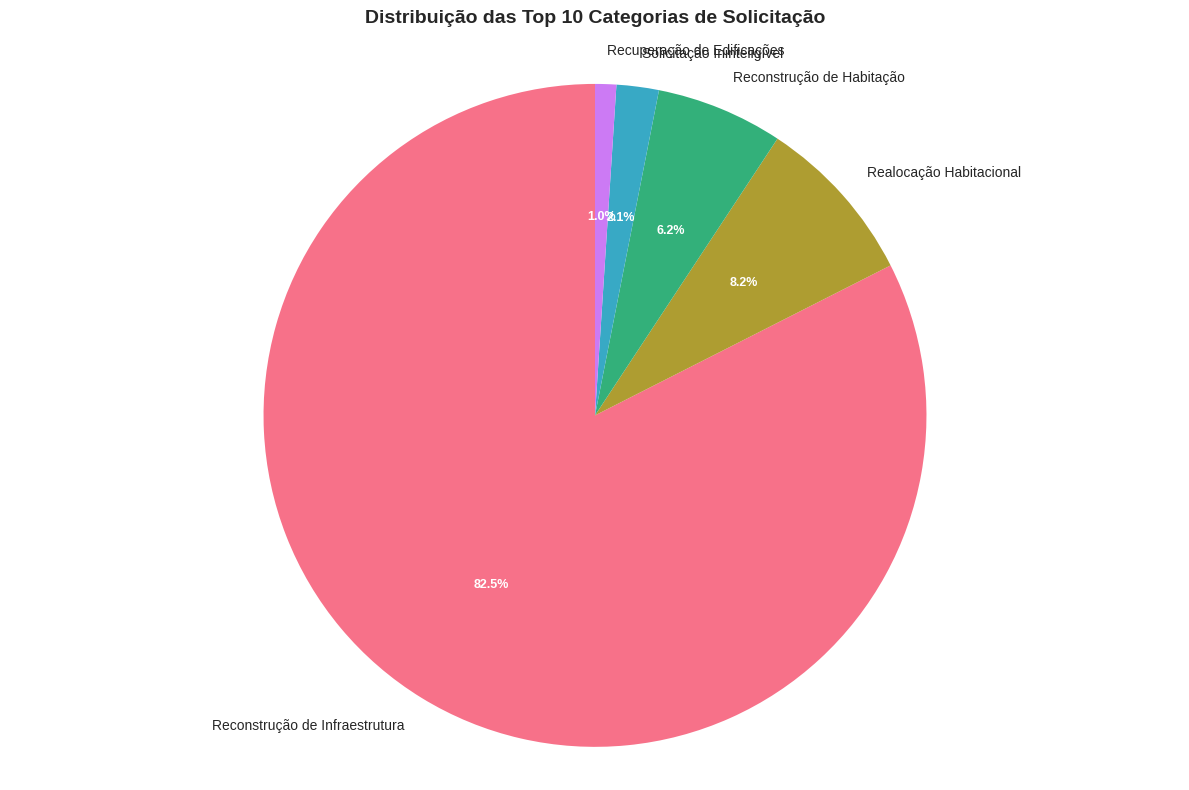

In [73]:
# Gráfico de pizza com as top 10 categorias
top_n = 10
top_categories = category_counts.head(top_n)

# Se houver mais categorias, agrupar as demais em "Outras"
if len(category_counts) > top_n:
    outras = category_counts[top_n:].sum()
    top_categories = pd.concat([top_categories, pd.Series({'Outras': outras})])

# Criar gráfico de pizza
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(top_categories))
wedges, texts, autotexts = plt.pie(
    top_categories.values,
    labels=top_categories.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 9}
)

# Melhorar legibilidade
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.title(f'Distribuição das Top {top_n} Categorias de Solicitação', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

### Gráfico de Barras - Frequência de Categorias

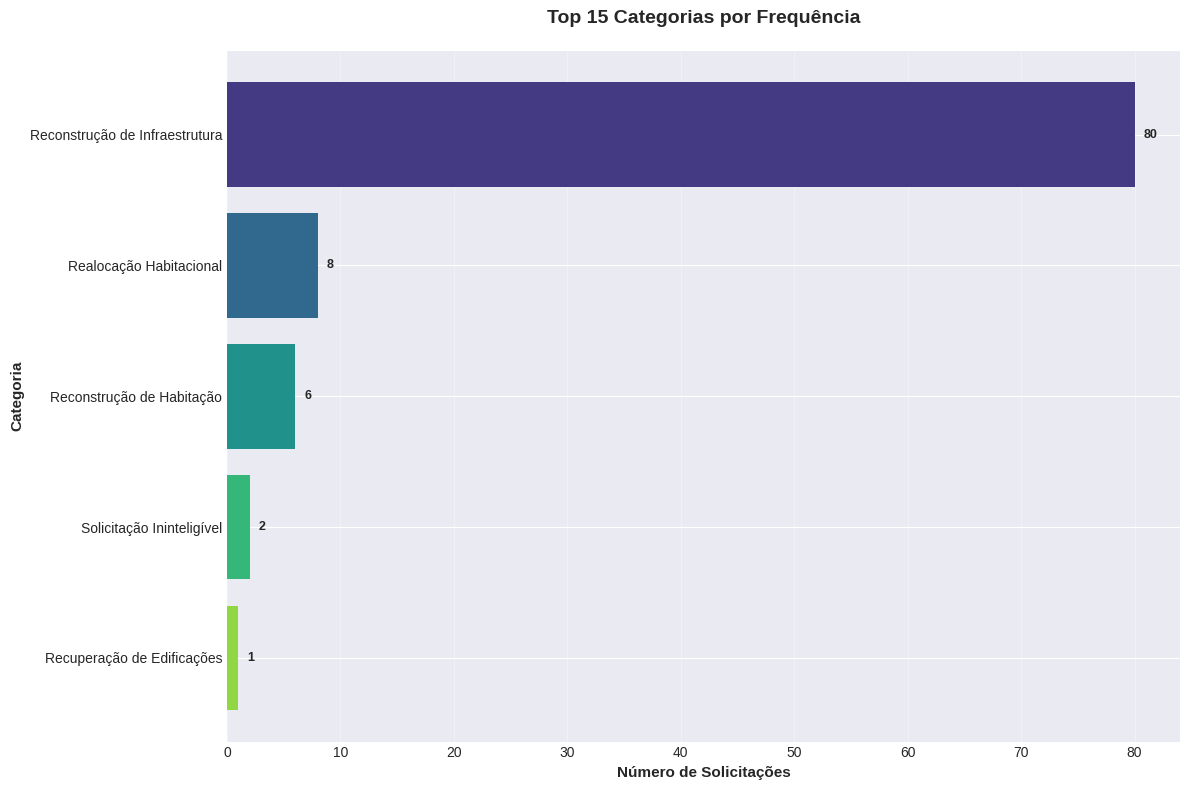

In [74]:
# Gráfico de barras horizontal com top 15 categorias
plt.figure(figsize=(12, 8))
top_15 = category_counts.head(15)

bars = plt.barh(range(len(top_15)), top_15.values, color=sns.color_palette("viridis", len(top_15)))
plt.yticks(range(len(top_15)), top_15.index, fontsize=10)
plt.xlabel('Número de Solicitações', fontsize=11, fontweight='bold')
plt.ylabel('Categoria', fontsize=11, fontweight='bold')
plt.title('Top 15 Categorias por Frequência', fontsize=14, fontweight='bold', pad=20)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, top_15.values)):
    plt.text(value + max(top_15.values) * 0.01, i, f'{value}', 
             va='center', fontsize=9, fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

### Comparação: Solicitações Classificadas vs Vazias

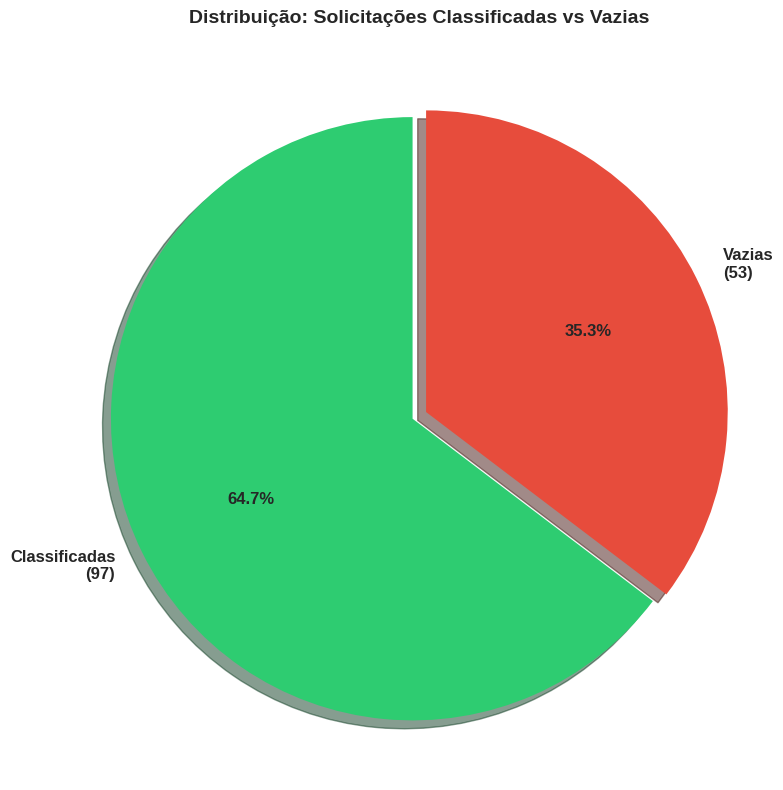


Resumo:
  • Total de registros: 150
  • Solicitações classificadas: 97 (64.7%)
  • Solicitações vazias: 53 (35.3%)


In [75]:
# Contar solicitações classificadas vs vazias
classificadas = len(df_categorias)
vazias = len(df) - classificadas

# Gráfico de pizza para comparação
plt.figure(figsize=(8, 8))
sizes = [classificadas, vazias]
labels = [f'Classificadas\n({classificadas})', f'Vazias\n({vazias})']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Distribuição: Solicitações Classificadas vs Vazias', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\nResumo:")
print(f"  • Total de registros: {len(df)}")
print(f"  • Solicitações classificadas: {classificadas} ({classificadas/len(df)*100:.1f}%)")
print(f"  • Solicitações vazias: {vazias} ({vazias/len(df)*100:.1f}%)")